# Même probléme, mais avec une approche Deep Learning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.random import seed
from numpy.random import randn,rand
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
#fonction pour calculer la surface d'un rectangle
def rectArea(length,width,rnd=False):
    if not rnd:
        return length*width
    else:
        return ((length*width)+randn(1)[0]*5)

#### Génération aléatoire de 200 couples de Longueur/Largeur dans l'espace de calcul (20mx20m)
Ensuite nous allons calculer la surface de ces 200 couples, en y ajoutant un biais de plus ou moins 5m²
et nous nous servirons de ces données pour entrainer notre réseau de neurones

In [4]:
seed(47)
width = rand(1, 200)*20
length = rand(1, 200)*20
width=width.ravel()
length=length.ravel()

area=list()
seed(1)
for w,l in zip(width,length):
    area.append(rectArea(w,l,True))

df = pd.DataFrame({'Width' : width,
                   'Length' : length,
                   'Area' : area})

X=df[['Width','Length']]
y=df['Area']

#### Import des librairiries TensorFlow et Keras (Google)

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.1.0


#### Normalisation des données

In [8]:
# X contient les 200 couples de Longueur/Largeur
# Le deep learning utilise la descente de gradients pour trouver les meilleurs minimums locaux (meilleures solutions)
# La descente de grandient fonctionne mieux et plus rapidement sur des données normalisées (x-moyenne/std)
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X))

#### Utilisation d'un modéle avec 2 neurones d'entrée (nos 2 paramétres), deux couches cachées de 64 neurones avec activation ReLU (non linéaire) et 1 neurone de sortie (le résultat)
Il y a plusieurs fonctions d'activation possibles, ReLu (Rectified linear units) est une des plus courantes, car elles donne toujours des bons résultats.

In [9]:
def build_and_compile_model(norm):
    model = tf.keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
    ])

    # On veut minimiser l'erreur absolue
    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

#### Création et entrainement du modéle

In [10]:
# Récupération du modéle
model = build_and_compile_model(normalizer)
# Pour obtenir un résultat répétable, on initialise le moteur aléatoire avec une graine de 47
tf.random.set_seed(47)
# Entrainement / 1000 itérations
history = model.fit(
    X.astype('float32').values, y.values,
    # 1000 itérations
    epochs=1000,
    verbose=0,
    # Calcule l'erreur de validation sur 20% du jeu d'entrainement
    validation_split = 0.2)

#### Affichage de l'historique de l'entrainement

In [11]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 120])
    plt.xlabel('Epoch')
    plt.ylabel('Error [m²]')
    plt.legend()
    plt.grid(True)

#### Aprés 800 itérations, on voit que le modéle ne progresse quasiment plus
par ailleurs pour mesurer l'écart entre une bonne prédiction et la valeur souhaitée, nous avons choisi une MAE (erreur moyenne absolue). La MAE sur le jeu d'entrainement, et sur la validation se stabilisent au même niveau.

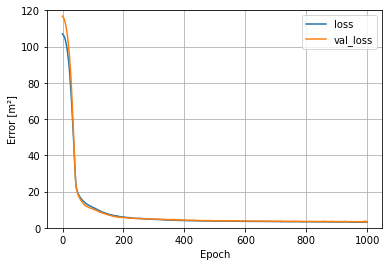

In [12]:
plot_loss(history)

#### notre modéle, réalise en moyenne une erreur de 3m² dans l'espace de travail 20x20m
Ce qui est plutôt une bonne performance, compte tenu du peut de valeurs fournies pour l'entrainement

In [13]:
# MAE finale sur le jeu d'entrainement (en m²)
np.round(history.history['loss'][-1],2)

3.08

#### Test du modéle obtenu avec quelques valeurs

In [14]:
X_test = np.array([[1.,1.],
                   [7.,7.],
                   [10.,10.],
                   [13.,13.],
                   [20.,20.]])
model.predict(X_test)
# Sans grosses surprises, le modéle fonctionne bien sur des valeurs médianes, et moins bien sur les extrémités
# car la densité de points (200 couples) n'est pas suffisante.
# Avec 2000 couples de données, notre modéle serait bien plus performant

array([[  3.937],
       [ 49.247],
       [ 99.876],
       [171.203],
       [386.341]], dtype=float32)

### Visualisons le résultat

In [15]:
import plotly
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go

#Jupyter setup
init_notebook_mode(connected=True)


x, y = np.linspace(0, 20, 21), np.linspace(0, 20, 21)
X, Y = np.meshgrid(x, y)
Z = rectArea(X,Y)
points=np.c_[X.ravel(), Y.ravel()]
Zhat = model.predict(points)


# Creating the plot
data = []
line_marker = dict(color='blue', width=2)
compt=0
for i, j, k in zip(X, Y, Z):
    if compt==0:
        data.append(go.Scatter3d(x=i, y=j, z=k, mode='lines', line=line_marker,opacity=0.5,name='valeurs réélles'))
    else:
        data.append(go.Scatter3d(x=i, y=j, z=k, mode='lines', line=line_marker,opacity=0.5,showlegend=False))
    data.append(go.Scatter3d(x=j, y=i, z=k, mode='lines', line=line_marker,opacity=0.5,showlegend=False))
    compt+=1

data.append(go.Surface(z=Zhat.reshape(21,-1), x=x, y=y , colorscale='Viridis',opacity=0.5,name='ANN',showscale=False,showlegend=True))
data.append(go.Scatter3d(x=df['Width'],y=df['Length'],z=df['Area'],
                         mode='markers',
                         marker=dict(size=2, color='red',opacity=1),marker_symbol='diamond',
                         name="Points d'entrainements"))
fig = go.Figure(data=data)  

fig.update_layout(
    width=800, height=800, autosize = True,
    legend_title="Légende des graphiques",
    font=dict(
        size=12,
        color="black"
    )
)

#font
fig.update_layout(
    font_size=14,
    font_family="Courier New",
    font_color="blue",
    legend_title_font_color="black")

#camera position
fig.update_layout(scene_camera=dict(eye=dict(x=1.25, y=0.75, z=0.85)))

#legend
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.85,
    xanchor="left",
    x=0.01
))

#axes
fig.update_layout(
    scene = dict(xaxis_title='Longueur (m)',
                yaxis_title='Largeur (m)',
                zaxis_title='Surface (m²)',
                xaxis = dict(nticks=5, range=[0,20]),
                yaxis = dict(nticks=5, range=[0,20]),
                zaxis = dict(nticks=10, range=[0,400])))
#title
fig.update_layout(
    title={
        'text': "<b>Prédictions du réseau de neurones</b>",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font' :  dict(
                family="Arial",
                size=20,
                color='#000000')
    })


fig.show()

#### Repartition des erreurs

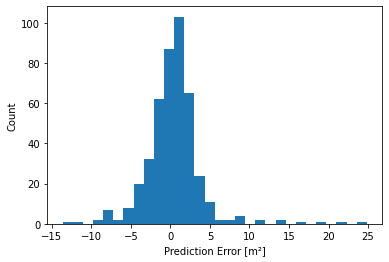

In [16]:
error = Zhat.ravel()-Z.ravel()
plt.hist(error,bins=30)
plt.xlabel('Prediction Error [m²]')
_ =plt.ylabel('Count')